In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score, balanced_accuracy_score
import pyswarms as ps

Loading CIFAR-100 dataset...
169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Dataset loaded successfully.

--- Data Inspection and Preprocessing ---
Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
Input shape for model: (32, 32, 3)
Number of classes: 100


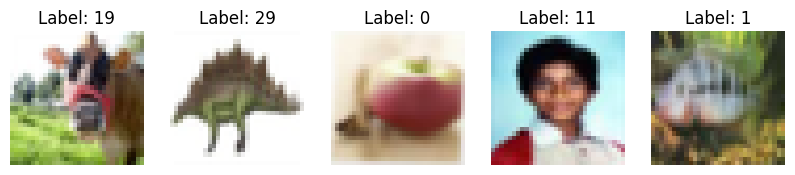

In [ ]:
# --- LOAD DATA ---
print("Loading CIFAR-100 dataset...")
(X_train_full, y_train_full), (X_test, y_test) = cifar100.load_data()
print("Dataset loaded successfully.")

# --- DATA PREPROCESSING ---
# Scale pixel values from 0-255 to 0-1
X_train_full = X_train_full.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Define constants
INPUT_SHAPE = X_train_full.shape[1:]
NUM_CLASSES = len(np.unique(y_train_full))

print("\n--- Data Inspection and Preprocessing ---")
print(f"Training data shape: {X_train_full.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Input shape for model: {INPUT_SHAPE}")
print(f"Number of classes: {NUM_CLASSES}")

plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train_full[i])
    plt.title(f"Label: {y_train_full[i][0]}")
    plt.axis('off')
plt.show()

In [3]:

tf.random.set_seed(42)
np.random.seed(42)

# Define the Baseline CNN Model
print("--- Building Baseline CNN Model for CIFAR-100 ---")

baseline_model = Sequential([
    Input(shape=INPUT_SHAPE),
    
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the Model
baseline_model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

baseline_model.summary()

# Train the Baseline Model
print("\n--- Training Baseline Model ---")
baseline_early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=15,        
    restore_best_weights=True,
    mode='max',
    verbose=1
)

history_baseline = baseline_model.fit(
    X_train_full, y_train_full,
    epochs=100,
    batch_size=64, 
    validation_split=0.2, 
    callbacks=[baseline_early_stopping],
    verbose=1
)

# Evaluate the Baseline Model
print("\n--- Evaluating Baseline Model on Test Set ---")
loss_baseline, accuracy_baseline = baseline_model.evaluate(X_test, y_test, verbose=0)
print(f"\nBaseline Model Test Loss: {loss_baseline:.4f}")
print(f"Baseline Model Test Accuracy: {accuracy_baseline:.4f}")

# Get full metrics
y_pred_probs_baseline = baseline_model.predict(X_test)
y_pred_baseline = np.argmax(y_pred_probs_baseline, axis=1)

print("\nBaseline Model Classification Report (Top 5 classes and summary):")
baseline_report_dict = classification_report(y_test, y_pred_baseline, output_dict=True)
print(f"Macro Avg F1-score: {baseline_report_dict['macro avg']['f1-score']:.4f}")
print(f"Weighted Avg F1-score: {baseline_report_dict['weighted avg']['f1-score']:.4f}")


# Store all metrics for final comparison
baseline_mcc = matthews_corrcoef(y_test, y_pred_baseline)
baseline_cohen_kappa = cohen_kappa_score(y_test, y_pred_baseline)
baseline_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_baseline)
baseline_macro_f1 = baseline_report_dict['macro avg']['f1-score']
baseline_weighted_f1 = baseline_report_dict['weighted avg']['f1-score']

print(f"Baseline Matthews Correlation Coefficient (MCC): {baseline_mcc:.4f}")
print(f"Baseline Cohen's Kappa: {baseline_cohen_kappa:.4f}")
print(f"Baseline Balanced Accuracy: {baseline_balanced_accuracy:.4f}")

--- Building Baseline CNN Model for CIFAR-100 ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,391,236 (5.31 MB)

 Trainable params: 1,389,316 (5.30 MB)

 Non-trainable params: 1,920 (7.50 KB)


--- Training Baseline Model ---
Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.0692 - loss: 4.6745 - val_accuracy: 0.2026 - val_loss: 3.3838
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.2028 - loss: 3.3694 - val_accuracy: 0.2663 - val_loss: 3.0826
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.2881 - loss: 2.8543 - val_accuracy: 0.3593 - val_loss: 2.5151
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.3379 - loss: 2.5813 - val_accuracy: 0.3988 - val_loss: 2.3086
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.3743 - loss: 2.3928 - val_accuracy: 0.4178 - val_loss: 2.2434
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.4087 - loss: 2.2399 - val_accuracy: 0.4306 - val_loss: 2.1983
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.4367 - loss: 2.1047 - val_accuracy: 0.4518 - val_loss: 2.0859
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/

In [6]:
# Split training data for PSO's internal validation
X_train_pso, X_val_pso, y_train_pso, y_val_pso = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=123, stratify=y_train_full
)

print("--- PSO Optimization Setup for CIFAR-100 ---")
print(f"PSO training set size: {X_train_pso.shape}")
print(f"PSO validation set size: {X_val_pso.shape}")


# Define Hyperparameter Search Space for the CNN
min_bounds = np.array([16, 32, 64,  128, 0.0001])
max_bounds = np.array([64, 128, 256, 1024, 0.01])
bounds_pso = (min_bounds, max_bounds)
n_dimensions = len(min_bounds)

# Define PSO Objective Function
pso_iteration_count = 0
def cnn_fitness_function_cifar(params):
    global pso_iteration_count
    pso_iteration_count += 1

    # Unpack hyperparameters
    f1 = int(round(params[0]))
    f2 = int(round(params[1]))
    f3 = int(round(params[2]))
    d1 = int(round(params[3]))
    lr = float(params[4])

    print(f"\nPSO Eval {pso_iteration_count}: F1={f1}, F2={f2}, F3={f3}, Dense={d1}, LR={lr:.5f}", end="")

    tf.keras.backend.clear_session()
    tf.random.set_seed(42 + pso_iteration_count)
    np.random.seed(42 + pso_iteration_count)

    model_pso = Sequential([
        Input(shape=INPUT_SHAPE),
        Conv2D(f1, (3, 3), padding='same', activation='relu'), BatchNormalization(),
        Conv2D(f1, (3, 3), padding='same', activation='relu'), BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)), Dropout(0.2),
        
        Conv2D(f2, (3, 3), padding='same', activation='relu'), BatchNormalization(),
        Conv2D(f2, (3, 3), padding='same', activation='relu'), BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)), Dropout(0.3),
        
        Conv2D(f3, (3, 3), padding='same', activation='relu'), BatchNormalization(),
        Conv2D(f3, (3, 3), padding='same', activation='relu'), BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)), Dropout(0.4),

        Flatten(),
        Dense(d1, activation='relu'), BatchNormalization(),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=lr)
    model_pso.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # More aggressive early stopping for the quick PSO evaluation
    early_stop_pso = EarlyStopping(monitor='val_accuracy', mode='max', patience=8, restore_best_weights=True, verbose=0)
    
    history_pso = model_pso.fit(
        X_train_pso, y_train_pso,
        epochs=30, 
        batch_size=64,
        validation_data=(X_val_pso, y_val_pso),
        callbacks=[early_stop_pso],
        verbose=0
    )
    
    val_accuracy = np.max(history_pso.history.get('val_accuracy', [0]))
    print(f" -> Best Val Acc: {val_accuracy:.4f}")
    
    return 1.0 - val_accuracy

def pso_objective_wrapper(particles_batch):
    return np.array([cnn_fitness_function_cifar(p) for p in particles_batch])

# Configure and Run PSO
n_particles_pso = 5
pso_iters = 5

options_pso = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
print(f"\nStarting PSO with {n_particles_pso} particles for {pso_iters} iterations.")

pso_optimizer = ps.single.GlobalBestPSO(
    n_particles=n_particles_pso, dimensions=n_dimensions, options=options_pso, bounds=bounds_pso
)

best_cost_pso, best_params_pso = pso_optimizer.optimize(pso_objective_wrapper, iters=pso_iters, verbose=True)

print("\n--- PSO Optimization Finished ---")
print(f"Best cost (1 - val_accuracy) from PSO: {best_cost_pso:.4f}")
print(f"This implies a best validation accuracy of: {1.0 - best_cost_pso:.4f}")

best_f1 = int(round(best_params_pso[0]))
best_f2 = int(round(best_params_pso[1]))
best_f3 = int(round(best_params_pso[2]))
best_d1 = int(round(best_params_pso[3]))
best_lr = float(best_params_pso[4])

print("\nFormatted Best Hyperparameters from PSO:")
print(f"  Filters: Block1={best_f1}, Block2={best_f2}, Block3={best_f3}")
print(f"  Dense Units: {best_d1}")
print(f"  Learning Rate: {best_lr:.6f}")

2025-06-15 14:54:20,934 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--- PSO Optimization Setup for CIFAR-100 ---
PSO training set size: (40000, 32, 32, 3)
PSO validation set size: (10000, 32, 32, 3)

Starting PSO with 5 particles for 5 iterations.


pyswarms.single.global_best:   0%|          |0/5


PSO Eval 1: F1=51, F2=75, F3=172, Dense=496, LR=0.00730 -> Best Val Acc: 0.5561

PSO Eval 2: F1=35, F2=96, F3=199, Dense=674, LR=0.00545 -> Best Val Acc: 0.5579

PSO Eval 3: F1=26, F2=51, F3=217, Dense=388, LR=0.00659 -> Best Val Acc: 0.5457

PSO Eval 4: F1=30, F2=46, F3=142, Dense=406, LR=0.00251 -> Best Val Acc: 0.5671

PSO Eval 5: F1=44, F2=56, F3=208, Dense=773, LR=0.00698

pyswarms.single.global_best:  20%|██        |1/5, best_cost=0.433

 -> Best Val Acc: 0.5471

PSO Eval 6: F1=47, F2=71, F3=164, Dense=483, LR=0.00756 -> Best Val Acc: 0.5646

PSO Eval 7: F1=35, F2=93, F3=200, Dense=603, LR=0.00244 -> Best Val Acc: 0.5737

PSO Eval 8: F1=27, F2=50, F3=211, Dense=390, LR=0.00170 -> Best Val Acc: 0.5649

PSO Eval 9: F1=31, F2=47, F3=142, Dense=407, LR=0.00045 -> Best Val Acc: 0.5526

PSO Eval 10: F1=43, F2=55, F3=189, Dense=758, LR=0.00714

pyswarms.single.global_best:  40%|████      |2/5, best_cost=0.426

 -> Best Val Acc: 0.5348

PSO Eval 11: F1=41, F2=69, F3=165, Dense=500, LR=0.00918 -> Best Val Acc: 0.5434

PSO Eval 12: F1=35, F2=90, F3=201, Dense=539, LR=0.00568 -> Best Val Acc: 0.5503

PSO Eval 13: F1=30, F2=55, F3=205, Dense=447, LR=0.00126 -> Best Val Acc: 0.5705

PSO Eval 14: F1=32, F2=48, F3=151, Dense=458, LR=0.00265 -> Best Val Acc: 0.5658

PSO Eval 15: F1=40, F2=56, F3=175, Dense=710, LR=0.00034

pyswarms.single.global_best:  60%|██████    |3/5, best_cost=0.426

 -> Best Val Acc: 0.5615

PSO Eval 16: F1=35, F2=67, F3=174, Dense=513, LR=0.00419 -> Best Val Acc: 0.5580

PSO Eval 17: F1=35, F2=88, F3=201, Dense=499, LR=0.00844 -> Best Val Acc: 0.5600

PSO Eval 18: F1=33, F2=66, F3=199, Dense=502, LR=0.00118 -> Best Val Acc: 0.5815

PSO Eval 19: F1=33, F2=57, F3=172, Dense=503, LR=0.00956 -> Best Val Acc: 0.5377

PSO Eval 20: F1=36, F2=62, F3=165, Dense=646, LR=0.00360

pyswarms.single.global_best:  80%|████████  |4/5, best_cost=0.419

 -> Best Val Acc: 0.5633

PSO Eval 21: F1=30, F2=66, F3=182, Dense=518, LR=0.00546 -> Best Val Acc: 0.5478

PSO Eval 22: F1=35, F2=85, F3=200, Dense=475, LR=0.00219 -> Best Val Acc: 0.5653

PSO Eval 23: F1=36, F2=77, F3=193, Dense=551, LR=0.00606 -> Best Val Acc: 0.5628

PSO Eval 24: F1=34, F2=65, F3=178, Dense=534, LR=0.00144 -> Best Val Acc: 0.5785

PSO Eval 25: F1=33, F2=68, F3=164, Dense=558, LR=0.00096

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=0.419
2025-06-15 21:22:58,778 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.41850000619888306, best pos: [3.31375080e+01 6.63929291e+01 1.98950130e+02 5.01942790e+02
 1.17825716e-03]


 -> Best Val Acc: 0.5683

--- PSO Optimization Finished ---
Best cost (1 - val_accuracy) from PSO: 0.4185
This implies a best validation accuracy of: 0.5815

Formatted Best Hyperparameters from PSO:
  Filters: Block1=33, Block2=66, Block3=199
  Dense Units: 502
  Learning Rate: 0.001178


In [7]:
# Define the Final PSO-Optimized CNN Model
print("\n--- Training Final Model with PSO-Optimized Hyperparameters ---")

final_model_pso = Sequential([
    Input(shape=INPUT_SHAPE),
    Conv2D(best_f1, (3, 3), padding='same', activation='relu'), BatchNormalization(),
    Conv2D(best_f1, (3, 3), padding='same', activation='relu'), BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)), Dropout(0.2),
    
    Conv2D(best_f2, (3, 3), padding='same', activation='relu'), BatchNormalization(),
    Conv2D(best_f2, (3, 3), padding='same', activation='relu'), BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)), Dropout(0.3),
    
    Conv2D(best_f3, (3, 3), padding='same', activation='relu'), BatchNormalization(),
    Conv2D(best_f3, (3, 3), padding='same', activation='relu'), BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)), Dropout(0.4),

    Flatten(),
    Dense(best_d1, activation='relu'), BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the Final Model
final_optimizer = Adam(learning_rate=best_lr)
final_model_pso.compile(
    optimizer=final_optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
final_model_pso.summary()

# Train the Final Model
print("\n--- Training Final PSO-Optimized Model ---")
final_early_stopping = EarlyStopping(
    monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True, verbose=1
)

history_final_pso = final_model_pso.fit(
    X_train_full, y_train_full,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[final_early_stopping],
    verbose=1
)

# Evaluate the Final PSO-Optimized Model
print("\n--- Evaluating PSO Optimized Model on Test Set ---")
loss_final_pso, accuracy_final_pso = final_model_pso.evaluate(X_test, y_test, verbose=0)
print(f"\nPSO Optimized Test Accuracy: {accuracy_final_pso:.4f}")

# Get full metrics
y_pred_probs_pso = final_model_pso.predict(X_test)
y_pred_pso = np.argmax(y_pred_probs_pso, axis=1)

print("\nPSO Optimized Model Classification Report (Summary):")
pso_report_dict = classification_report(y_test, y_pred_pso, output_dict=True)
print(f"Macro Avg F1-score: {pso_report_dict['macro avg']['f1-score']:.4f}")
print(f"Weighted Avg F1-score: {pso_report_dict['weighted avg']['f1-score']:.4f}")

pso_mcc = matthews_corrcoef(y_test, y_pred_pso)
pso_cohen_kappa = cohen_kappa_score(y_test, y_pred_pso)
pso_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_pso)

print(f"PSO Optimized Matthews Correlation Coefficient (MCC): {pso_mcc:.4f}")
print(f"PSO Optimized Cohen's Kappa: {pso_cohen_kappa:.4f}")
print(f"PSO Optimized Balanced Accuracy: {pso_balanced_accuracy:.4f}")


# Final Comparison Table and Analysis
print("\n\n--- Comparison of Model Performance ---")

comparison_data = {
    "Metric": ["Accuracy", "Balanced Accuracy", "Macro F1-score", "Weighted F1-score", "MCC", "Cohen's Kappa"],
    "Baseline Model": [accuracy_baseline, baseline_balanced_accuracy, baseline_macro_f1, baseline_weighted_f1, baseline_mcc, baseline_cohen_kappa],
    "PSO Optimized Model": [accuracy_final_pso, pso_balanced_accuracy, pso_report_dict['macro avg']['f1-score'], pso_report_dict['weighted avg']['f1-score'], pso_mcc, pso_cohen_kappa]
}
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False, float_format="%.4f"))


--- Training Final Model with PSO-Optimized Hyperparameters ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 33)     │           924 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 33)     │           132 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 33)     │         9,834 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 33)     │           132 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 33)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 33)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 66)     │        19,668 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 66)     │           264 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 66)     │        39,270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 66)     │           264 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 66)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 66)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 199)      │       118,405 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 199)      │           796 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 199)      │       356,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 8, 8, 199)      │           796 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 199)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 199)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 502)            │     1,598,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 502)            │         2,008 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,198,271 (8.39 MB)

 Trainable params: 2,196,075 (8.38 MB)

 Non-trainable params: 2,196 (8.58 KB)


--- Training Final PSO-Optimized Model ---
Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 49ms/step - accuracy: 0.0751 - loss: 4.6238 - val_accuracy: 0.2241 - val_loss: 3.2172
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.2092 - loss: 3.3299 - val_accuracy: 0.3150 - val_loss: 2.7284
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.3073 - loss: 2.7317 - val_accuracy: 0.3907 - val_loss: 2.3487
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.3699 - loss: 2.4084 - val_accuracy: 0.4225 - val_loss: 2.1868
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.4128 - loss: 2.2277 - val_accuracy: 0.4481 - val_loss: 2.0859
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.4494 - loss: 2.0440 - val_accuracy: 0.4640 - val_loss: 2.0096
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.4784 - loss: 1.8998 - val_accuracy: 0.4817 - val_loss: 1.9318
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━

# Analysis and Conclusion for CIFAR-100 Dataset

The CIFAR-100 image classification task served as a classic computer vision problem to test the PSO methodology on a well-structured, balanced dataset.

---

## Baseline Model Performance

- The baseline CNN, using a standard deep architecture and default hyperparameters, established a **strong performance benchmark**.
- It achieved a **test accuracy of 58.97%**, which is significantly better than random chance (1% for 100 classes).
- This result demonstrated that the architecture was well-suited for the task.
- The central question became: _Could PSO refine the hyperparameters to achieve further gains?_

---

## PSO Optimization Results

- The PSO algorithm explored **25 different hyperparameter combinations**.
- Key findings include:
  - The best-performing particle in the validation phase achieved **58.15%** accuracy.
  - The optimal hyperparameters identified were:  
    - **Filters:** 33, 66, 199  
    - **Dense Units:** 502  
    - **Learning Rate:** 0.001178

- These values were **remarkably close** to the baseline configuration, indicating that:
  > For this specific problem, the baseline architecture was already near an optimal point in the hyperparameter space.

---

## Final Model Comparison

| Metric            | Baseline Model | PSO Optimized Model | Change                |
|-------------------|----------------|----------------------|------------------------|
| Accuracy          | 0.5897         | 0.5975               | ✅ **+0.78%**          |
| Balanced Accuracy | 0.5897         | 0.5975               | ✅ **+0.78%**          |
| Macro F1-score    | 0.5868         | 0.5954               | ✅ **+0.86%**          |
| MCC               | 0.5857         | 0.5935               | ✅ **+0.78%**          |
| Cohen's Kappa     | 0.5856         | 0.5934               | ✅ **+0.78%**          |

> The PSO-optimized model achieved a **test accuracy of 59.75%**, representing a small but consistent improvement across all evaluation metrics.

---

## Overall Conclusion

This experiment demonstrates a **different, yet equally important**, outcome of hyperparameter optimization:

- Unlike the **FMA audio task**, where PSO had to find a radically new solution to fix a failing model,
- Here, PSO provided **fine-tuning refinement** on a problem where the **baseline was already strong**.

### Key Insight:

> PSO acted as an effective **local search**, confirming the quality of the original architecture and finding small tweaks that **polished performance**.

This highlights the **versatility** of Particle Swarm Optimization:
- 🔍 **Broad, exploratory search** on difficult problems
- 🔧 **Fine-grained optimization** on well-behaved datasets

**PSO delivers value in both scenarios.**
